In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"C:\Users\athar\OneDrive\Desktop\TY SEM 1 STUDY MATERIAL\SDP FACE MASK\Face-Mask-Detection\dataset"
CATEGORIES = ["with_mask", "without_mask"]
#We are dividing the dataset loaded in 2 cateories ie. with mask & without mask

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

#Here we are going to append all the imagearray dataset
data = [] 
#We are going to append all corresponding images which are with mask or without mask
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)#We are joining all the dataset within directory which have 2 categories
    for img in os.listdir(path):
        #Joining the path of with mask with that corresponding dataset
    	img_path = os.path.join(path, img) 
        #Loads image path and initializes the target path = size of image ie. 224*224
    	image = load_img(img_path, target_size=(224, 224))
        #Converting Image to an Array
    	image = img_to_array(image)
        #We need to preprocess our data as we are using it for MobileNet
    	image = preprocess_input(image)
        
        #Append the array in Data List
    	data.append(image)
        #Append the category of image to category label
    	labels.append(category)

# perform one-hot encoding on the labels
# we are converting categarical data ehich is in 2 formats now 'with mask' & 'without mask' into 0 & 1.
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

#Now we covert 0 & 1 into an numpy array
data = np.array(data, dtype="float32")
labels = np.array(labels)
#Here we converted data and label categorical data into numpy as it is essential to make deeplearning model.

#By train_test_split we are dividing the dataset in 2 parts 20% for testing and 80% for training
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
# Data Augmentation Creates various images by giving various transforms so that it can create more dataset
# Reference Link : https://keras.io/api/preprocessing/image/#imagedatagenerator-class
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
# With the help of MobileNetV2 we are making a base model
#Input Tensor means the shape of image that is going through the model
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output #In headmodel we are basing the basemodel output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
#Here the model function accepts 2 parameters input and output

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
#we are using adam optimizer and we are tracking the accuracy
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
metrics=["accuracy"])

# train the head of the network
# Here we are having less images so we are using image generator to train model.
# For Validating the data we are using the testing dataset

print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] loading images...


C:\Users\athar\ananew\anaconda3\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[INFO] compiling model...
[INFO] training head...
Epoch 1/20
95/95 [==============================] - 100s 1s/step - loss: 0.3542 - accuracy: 0.8444 - val_loss: 0.0990 - val_accuracy: 0.9765
Epoch 2/20
95/95 [==============================] - 113s 1s/step - loss: 0.1184 - accuracy: 0.9618 - val_loss: 0.0535 - val_accuracy: 0.9883
Epoch 3/20
95/95 [==============================] - 126s 1s/step - loss: 0.0859 - accuracy: 0.9720 - val_loss: 0.0443 - val_accuracy: 0.9909
Epoch 4/20
95/95 [==============================] - 118s 1s/step - loss: 0.0719 - accuracy: 0.9743 - val_loss: 0.0417 - val_accuracy: 0.9870
Epoch 5/20
95/95 [==============================] - 129s 1s/step - loss: 0.0611 - accuracy: 0.9796 - val_loss: 0.0345 - val_accuracy: 0.9909
Epoch 6/20
95/95 [==============================] - 132s 1s/step - loss: 0.0526 - accuracy: 0.9829 - val_loss: 0.0337 - val_accuracy: 0.9896
Epoch 7/20
95/95 [==============================] - 129s 1s/step - loss: 0.0469 - accuracy: 0.9819 - val

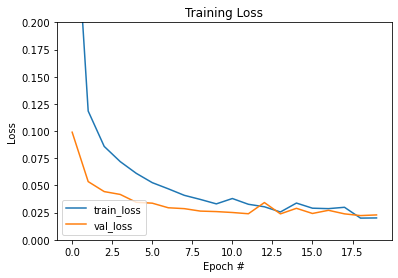

In [8]:
N=20
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.ylim([0, 0.2])
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("plot1.png")

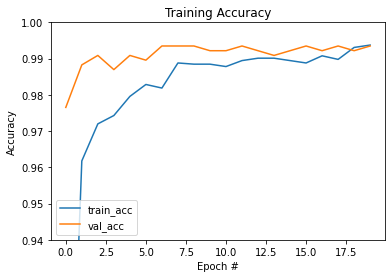

In [13]:
N=20
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.ylim([0.94, 1])
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot2.png")